# Pizza dataset analysis and price prediction

This projects analyzed data about pizza orders, each characterized by different features.<br>
![](http://)![](http://)![](http://)The goal of this project is to get interesting insights from the data and develop a prediction model to predict the price of a pizza given some features.

The best performing model was XGBoost, with rmse=8165 rupiah(0.49 eur) and r2=0.925

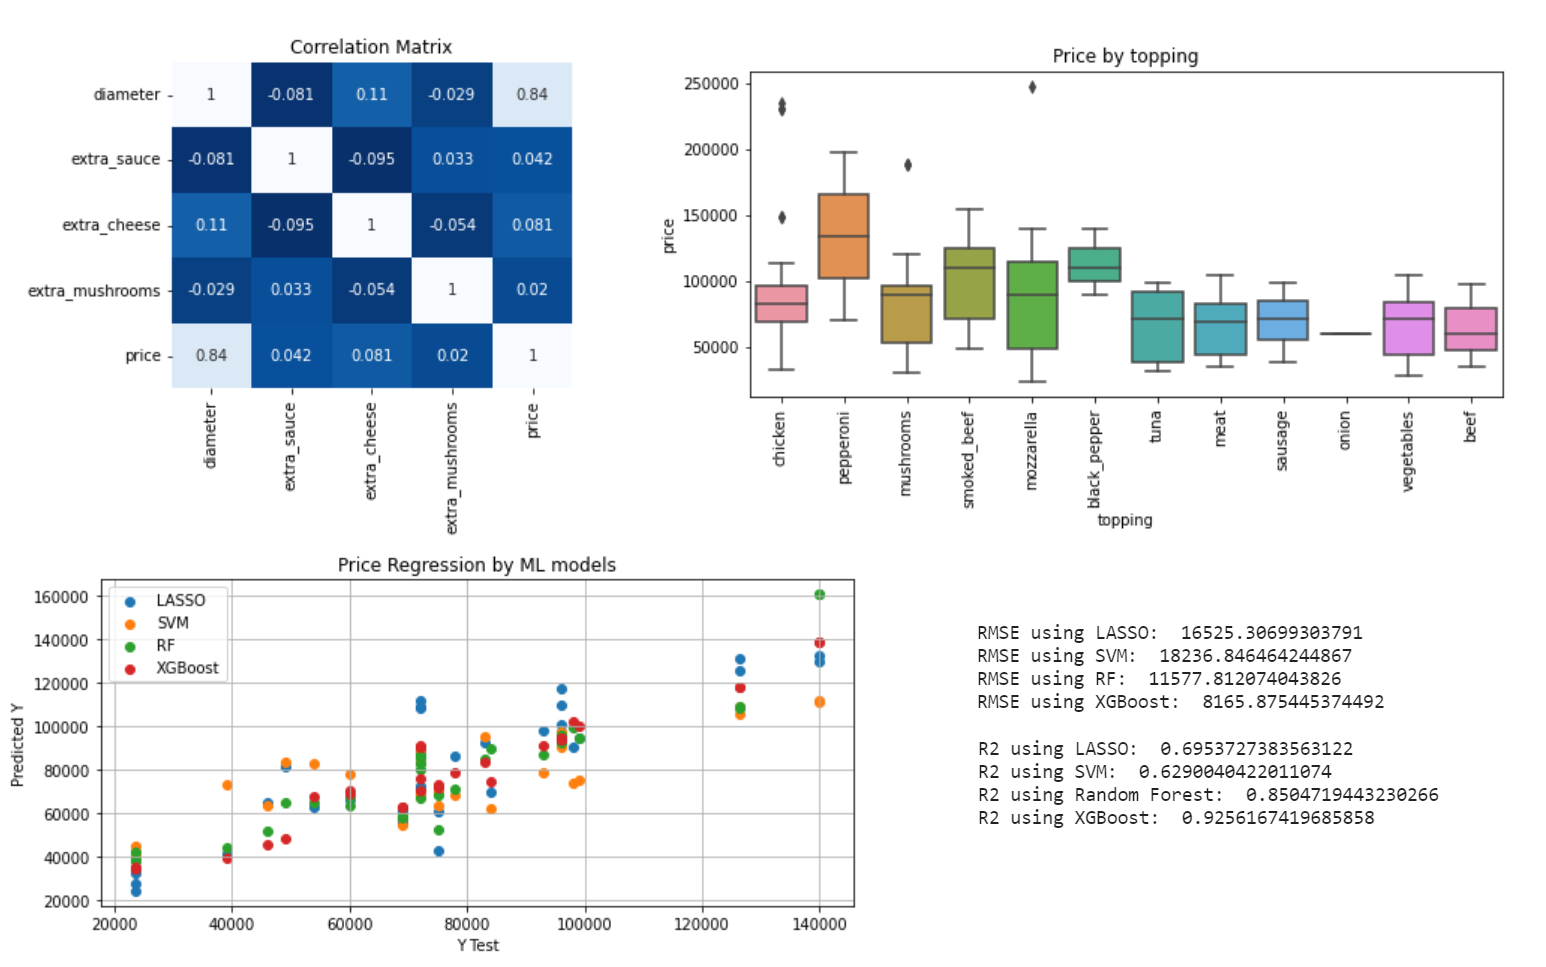
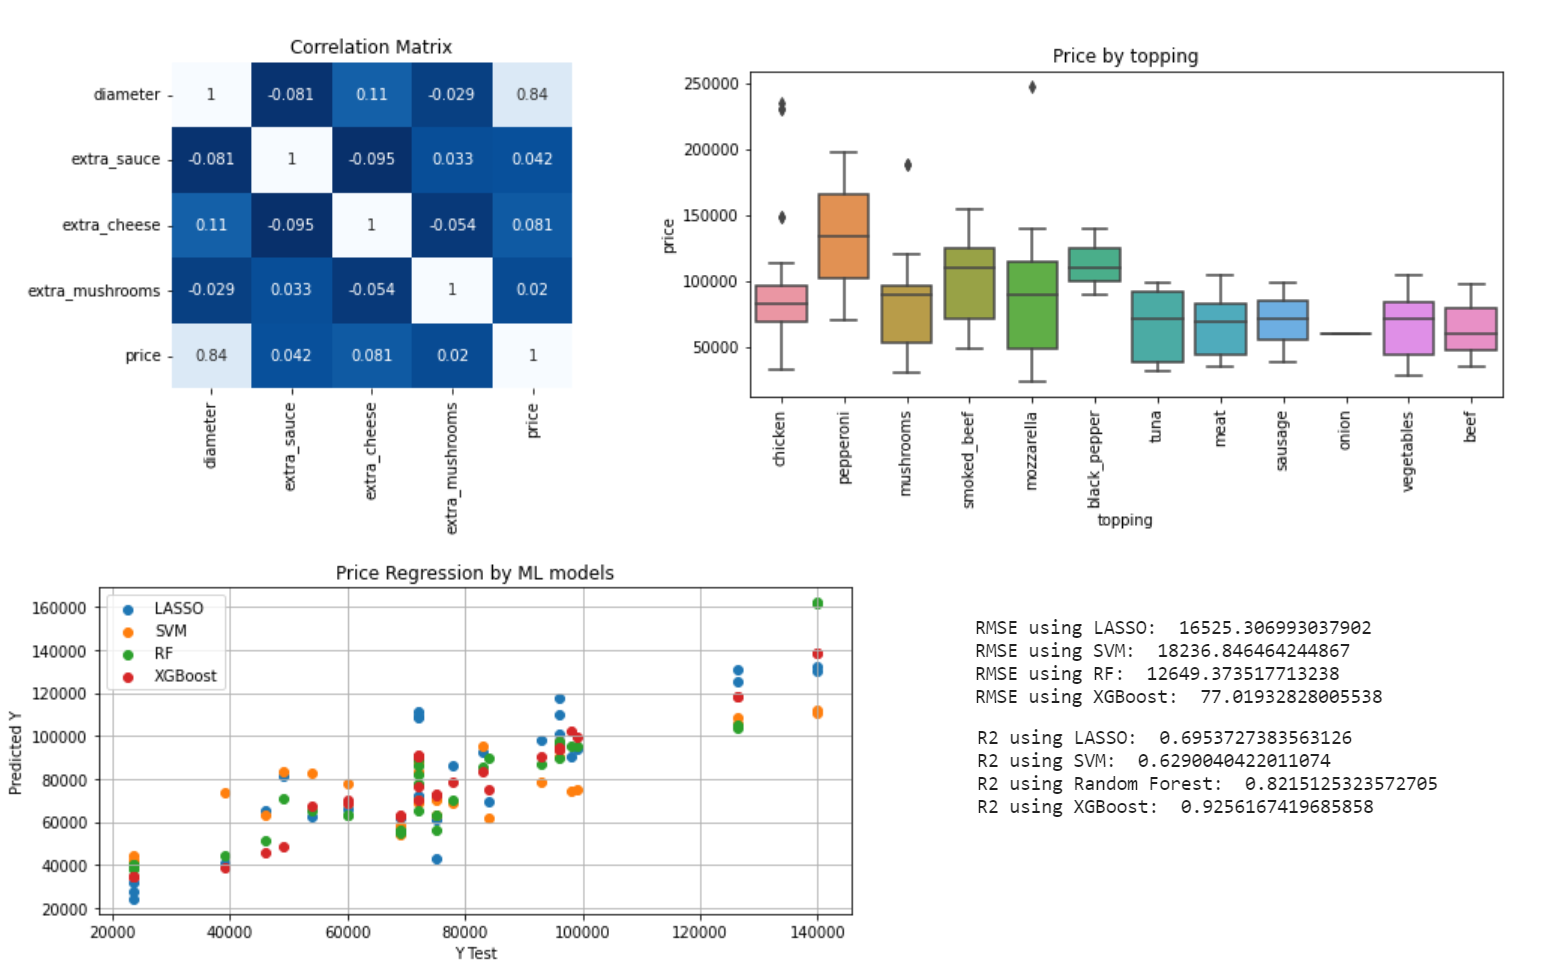

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pizza-price-prediction/pizza_v2.csv
/kaggle/input/pizza-price-prediction/pizza_v1.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/kaggle/input/pizza-price-prediction/pizza_v2.csv')
df.head()

company price_rupiah diameter      topping           variant     size  \
0       A    Rp235,000  22 inch      chicken  double_signature    jumbo   
1       A    Rp198,000  20 inch    papperoni  double_signature    jumbo   
2       A    Rp120,000  16 inch    mushrooms  double_signature  reguler   
3       A    Rp155,000  14 inch  smoked_beef  double_signature  reguler   
4       A    Rp248,000  18 inch   mozzarella  double_signature    jumbo   

  extra_sauce extra_cheese extra_mushrooms  
0         yes          yes              no  
1         yes          yes              no  
2         yes          yes             yes  
3         yes           no             yes  
4         yes           no             yes

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   company          129 non-null    object
 1   price_rupiah     129 non-null    object
 2   diameter         129 non-null    object
 3   topping          129 non-null    object
 4   variant          129 non-null    object
 5   size             129 non-null    object
 6   extra_sauce      129 non-null    object
 7   extra_cheese     129 non-null    object
 8   extra_mushrooms  129 non-null    object
dtypes: object(9)
memory usage: 9.2+ KB


We can already see that some numerical features such as price and diameter are saved as strings. They will be changed to int values.<br>

In [5]:
df['price_rupiah'] = df['price_rupiah'].replace(',','')

In [6]:
df.head()

company price_rupiah diameter      topping           variant     size  \
0       A    Rp235,000  22 inch      chicken  double_signature    jumbo   
1       A    Rp198,000  20 inch    papperoni  double_signature    jumbo   
2       A    Rp120,000  16 inch    mushrooms  double_signature  reguler   
3       A    Rp155,000  14 inch  smoked_beef  double_signature  reguler   
4       A    Rp248,000  18 inch   mozzarella  double_signature    jumbo   

  extra_sauce extra_cheese extra_mushrooms  
0         yes          yes              no  
1         yes          yes              no  
2         yes          yes             yes  
3         yes           no             yes  
4         yes           no             yes

In [7]:
#create a new column that will include the price 
df['price'] = df['price_rupiah'].replace(',', '').apply(lambda x: x[2:])

In [8]:
df = df.drop('price_rupiah', axis=1)

In [9]:
df['price'] = df['price'].apply(lambda x: x.replace(',',''))

In [10]:
df['price'] = df['price'].astype('int64')

In [11]:
#remove 'inch' from the diameter column
df['diameter'] = df['diameter'].apply(lambda x: x.replace('inch',''))

In [12]:
df['diameter'] = df['diameter'].astype('float')

In [13]:
df.head()

company  diameter      topping           variant     size extra_sauce  \
0       A      22.0      chicken  double_signature    jumbo         yes   
1       A      20.0    papperoni  double_signature    jumbo         yes   
2       A      16.0    mushrooms  double_signature  reguler         yes   
3       A      14.0  smoked_beef  double_signature  reguler         yes   
4       A      18.0   mozzarella  double_signature    jumbo         yes   

  extra_cheese extra_mushrooms   price  
0          yes              no  235000  
1          yes              no  198000  
2          yes             yes  120000  
3           no             yes  155000  
4           no             yes  248000

Now it is possible to extract useful information of these numerical features:

In [14]:
df.describe()

diameter          price
count  129.000000     129.000000
mean    12.976744   87151.162791
std      3.272674   44706.097732
min      8.000000   23500.000000
25%     12.000000   51000.000000
50%     12.000000   78000.000000
75%     14.000000  105000.000000
max     22.000000  248000.000000

Diameter:<br>
The mean diameter is around 13 inches<br>
The minimum diameter is 8 inches<br>
The maximum diameter is 22 inches<br>

Price:<br>
The mean price is 87,151 rupiah (around 5.20 euros)<br>
The cheapest pizza in the dataset is 23,500 rupiah (1.40 euro)<br>
The most expensive one is 248,000 rupiah (14.77 euro)<br>

# Exploratory Data Analysis

### Numerical features analysis

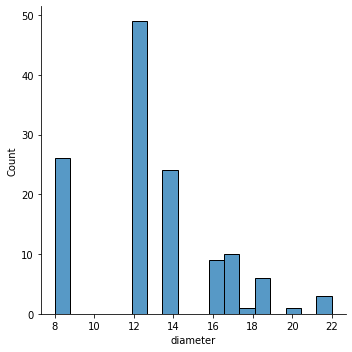

In [15]:
sns.displot(x='diameter', data=df, kde=False)

The diameter distribution is skewed right

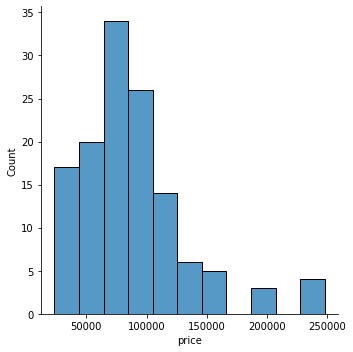

In [16]:
sns.displot(x='price', data=df)

The price distribition is right skewed as well.

### Topping analysis

In [17]:
df['topping']

0          chicken
1        papperoni
2        mushrooms
3      smoked_beef
4       mozzarella
          ...     
124           tuna
125           tuna
126           tuna
127           meat
128           meat
Name: topping, Length: 129, dtype: object

There seems to be two mispelling error: 'papperoni' instead of 'pepperoni' and 'black_papper' instead of 'black_pepper'. They will be corrected.

In [18]:
df['topping'] = df['topping'].replace('papperoni','pepperoni')
df['topping'] = df['topping'].replace('black_papper','black_pepper')

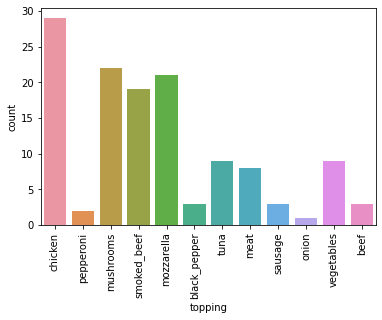

In [19]:
fig, ax=plt.subplots()
ax=sns.countplot(x='topping', data=df);
plt.xticks(rotation=90);
plt.show()

The most popular toppings among the pizzas are chicken, mushrooms, smoked_beef and mozzarella

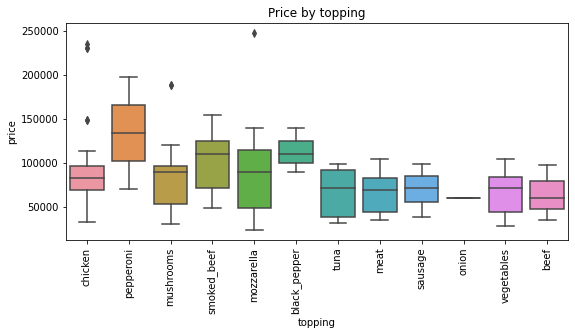

In [20]:
fig, ax = plt.subplots(figsize=(9,4))
sns.boxplot(x='topping', y='price', data=df)
plt.xticks(rotation=90);
ax.set_title('Price by topping');

From this plot we can say:<br>
Pepperoni pizza on average are more expensive than other pizzas.<br>
There are some outliers for mozzarella, mushrooms and chicken pizzas.<br>
It looks like there is just one onion pizza <br>


The only pizza with onions is:

In [21]:
df[df['topping']=='onion']

company  diameter topping       variant    size extra_sauce extra_cheese  \
59       C      12.0   onion  extravaganza  medium         yes          yes   

   extra_mushrooms  price  
59              no  60000

While the most expensive pizza is:

In [22]:
df[df['price'] > 240000]

company  diameter     topping           variant   size extra_sauce  \
4       A      18.0  mozzarella  double_signature  jumbo         yes   

  extra_cheese extra_mushrooms   price  
4           no             yes  248000

### Size analysis

In [23]:
df['size']

0        jumbo
1        jumbo
2      reguler
3      reguler
4        jumbo
        ...   
124      small
125     medium
126      large
127      small
128     medium
Name: size, Length: 129, dtype: object

There seems to be a mispelled word: 'reguler' instead of 'regular'. It will be corrected.

In [24]:
df['size'] = df['size'].replace('reguler','regular')

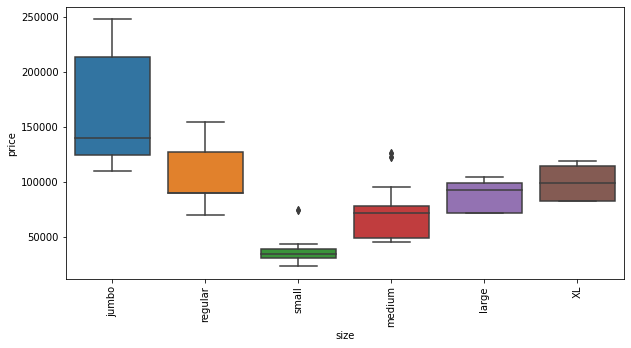

In [25]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='size', y='price', data=df)
plt.xticks(rotation=90);

From this plot jumbo and regular pizzas seems to be more expensive. This sounds a bit weird for regular pizzas, since they should be cheaper than larger pizzas like Xl and large. This will be further analyzed later.

### Variant analysis

The different pizza variants are:

In [26]:
df.variant.value_counts()

classic              30
meat_lovers          10
double_mix           10
crunchy              10
new_york             10
double_decker         9
double_signature      5
american_favorite     5
BBQ_meat_fiesta       5
super_supreme         5
spicy_tuna            3
BBQ_sausage           3
extravaganza          3
meat_eater            3
gournet_greek         3
italian_veggie        3
thai_veggie           3
american_classic      3
neptune_tuna          3
spicy tuna            3
Name: variant, dtype: int64

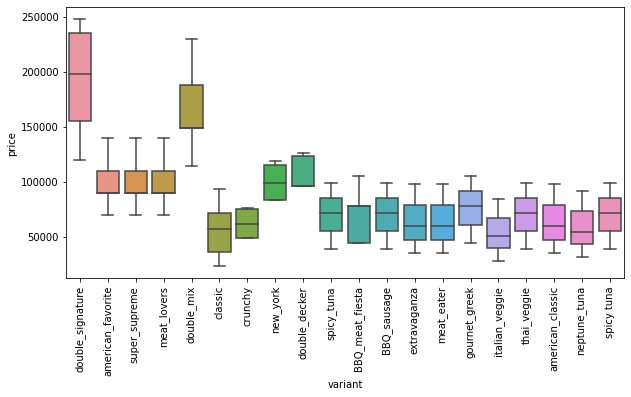

In [27]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='variant', y='price', data=df)
plt.xticks(rotation=90);

From this plot we can say that:<br>
Double signature and double mix pizzas are more expensive than the other pizzas.<br>
In particular, double signature pizza date has a large variance.<br>
Classic and italian veggies are cheaper on average.<br>

It could be interesting to check if there is a correlation between the variance, toppings and size (categorical variables))

### Extra-toppings analysis

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   company          129 non-null    object 
 1   diameter         129 non-null    float64
 2   topping          129 non-null    object 
 3   variant          129 non-null    object 
 4   size             129 non-null    object 
 5   extra_sauce      129 non-null    object 
 6   extra_cheese     129 non-null    object 
 7   extra_mushrooms  129 non-null    object 
 8   price            129 non-null    int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 9.2+ KB


<AxesSubplot:xlabel='extra_sauce', ylabel='count'>

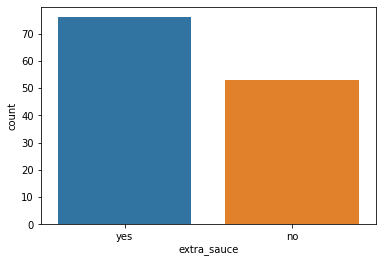

In [29]:
sns.countplot(x='extra_sauce', data=df)

<AxesSubplot:xlabel='extra_cheese', ylabel='count'>

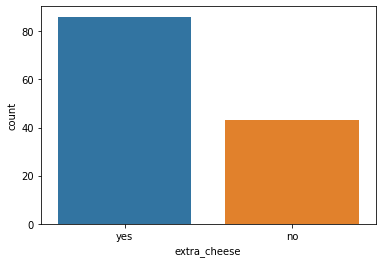

In [30]:
sns.countplot(x='extra_cheese', data=df)

<AxesSubplot:xlabel='extra_mushrooms', ylabel='count'>

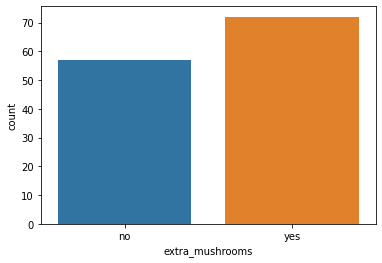

In [31]:
sns.countplot(x='extra_mushrooms', data=df)

From these plots we can see that on avergae, most pizzas have extra toppings (among mushrooms, cheese and sauce)<br>
In particular, the most added toppings is extra cheese

### Is there a correlation between the extra toppings?

To check the correlation between the extra toppings, yes and no will be first substitued by 1 and 0

In [32]:
df.replace(('yes', 'no'), (1, 0), inplace=True)

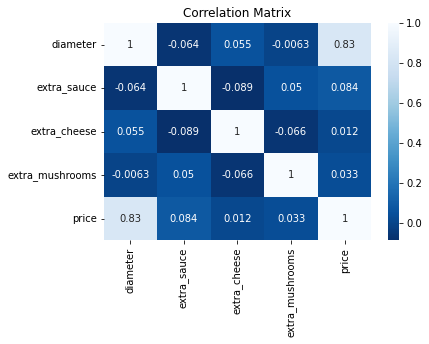

In [33]:
sns.heatmap(df.corr(), annot=True, cmap='Blues_r');
plt.title('Correlation Matrix');

It looks like that diameter is highly correlated with price, while other features does not seem to be correlated.

Moreover, the size feature could be converted into a numerical feature and analyzed.

<AxesSubplot:xlabel='size', ylabel='diameter'>

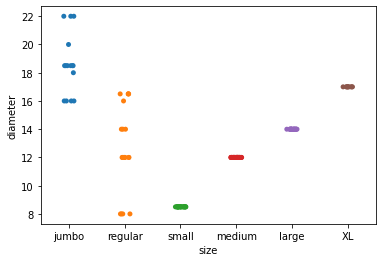

In [34]:
sns.stripplot(x='size', y='diameter', data=df)

Small pizza have a diameter of 8 inches <br>
Medium pizza have a diameter of 12 inches <br>
Large pizza have a diameter of 14 inches <br>
XL pizza have a diameter of 17 inches <br>

Interestingly, for 'regular' and 'jumbo' pizzas, the diameter is not fixed.<br>
This will be further analyzed.<br>

So, what makes a pizza jumbo or regular?

### Jumbo sized pizza analysis

In [35]:
df_jumbo = df[df['size'] == 'jumbo']
df_jumbo.head()

company  diameter       topping            variant   size  extra_sauce  \
0       A      22.0       chicken   double_signature  jumbo            1   
1       A      20.0     pepperoni   double_signature  jumbo            1   
4       A      18.0    mozzarella   double_signature  jumbo            1   
5       A      18.5  black_pepper  american_favorite  jumbo            0   
6       A      16.0   smoked_beef  american_favorite  jumbo            0   

   extra_cheese  extra_mushrooms   price  
0             1                0  235000  
1             1                0  198000  
4             0                1  248000  
5             0                1  140000  
6             1                1  110000

It looks like all these pizzas are from the company A, is that so?

In [36]:
df_jumbo.company.value_counts()

A    11
D     4
Name: company, dtype: int64

It looks like there are only 15 jumbo pizzas in the dataset. In particular among these 15, 11 are from the company A while the other 4 are from company D

In [37]:
df.company.value_counts()

C    30
E    30
A    25
B    24
D    20
Name: company, dtype: int64

For what concerns the original dataset, it seems to be banalced among different companies (from A to E)

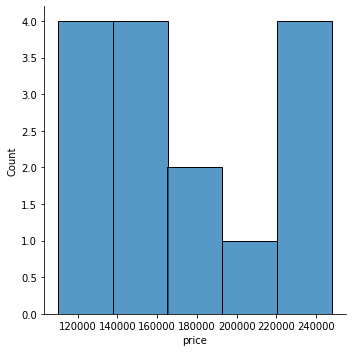

In [38]:
sns.displot(x='price', data=df_jumbo)

The minimum price is 125000 rupiah, which is higher than the average price of all pizzas ( around 87000 rupiah)

<AxesSubplot:xlabel='diameter', ylabel='count'>

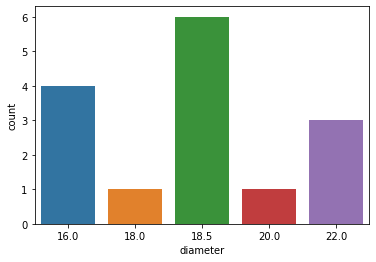

In [39]:
sns.countplot(x='diameter', data=df_jumbo)

Among jumbo pizzas, the diamater seems higher than 17 inches (XL size pizzas diameter).<br>
What about those jumbo pizzas with a 16 inches diameter?

In [40]:
df_jumbo[df_jumbo['diameter']==16]

company  diameter       topping            variant   size  extra_sauce  \
6        A      16.0   smoked_beef  american_favorite  jumbo            0   
11       A      16.0  black_pepper      super_supreme  jumbo            1   
16       A      16.0   smoked_beef        meat_lovers  jumbo            0   
80       D      16.0   smoked_beef        meat_lovers  jumbo            0   

    extra_cheese  extra_mushrooms   price  
6              1                1  110000  
11             1                0  110000  
16             1                1  110000  
80             1                0  110000

These 4 pizzas have a small diameter despite being a jumbo pizza. They will be considered as outliers and dropped.

In [41]:
df = df.loc[~((df['size'] == 'jumbo') & (df['diameter'] == 16)),:]

<AxesSubplot:xlabel='size', ylabel='diameter'>

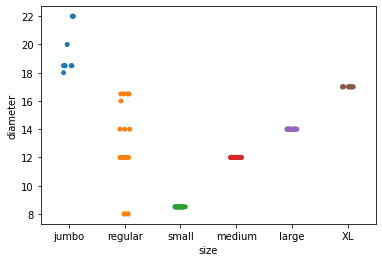

In [42]:
sns.stripplot(x='size', y='diameter', data=df)

## Regular pizza analysis

In [43]:
df_regular = df[df['size'] == 'regular']
df_regular.head()

company  diameter      topping            variant     size  extra_sauce  \
2       A      16.0    mushrooms   double_signature  regular            1   
3       A      14.0  smoked_beef   double_signature  regular            1   
7       A       8.0    pepperoni  american_favorite  regular            0   
8       A      12.0    mushrooms  american_favorite  regular            1   
9       A      12.0  smoked_beef  american_favorite  regular            0   

   extra_cheese  extra_mushrooms   price  
2             1                1  120000  
3             0                1  155000  
7             0                1   70000  
8             0                1   90000  
9             0                0   90000

In [44]:
df_regular.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 2 to 88
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   company          20 non-null     object 
 1   diameter         20 non-null     float64
 2   topping          20 non-null     object 
 3   variant          20 non-null     object 
 4   size             20 non-null     object 
 5   extra_sauce      20 non-null     int64  
 6   extra_cheese     20 non-null     int64  
 7   extra_mushrooms  20 non-null     int64  
 8   price            20 non-null     int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 1.6+ KB


In [45]:
df_regular.company.value_counts()

A    14
D     6
Name: company, dtype: int64

Like Jumbo pizzas, regular pizzas are only sold by company A and D

<AxesSubplot:xlabel='price', ylabel='count'>

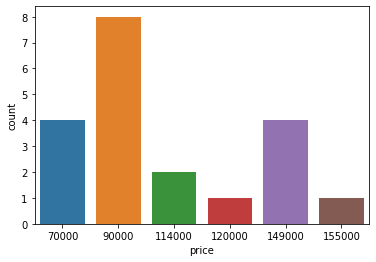

In [46]:
sns.countplot(x='price', data=df_regular)

Most regular pizza sems to have a price around 90000 rupiah, which is close to the overall average (87000)

<AxesSubplot:xlabel='diameter', ylabel='count'>

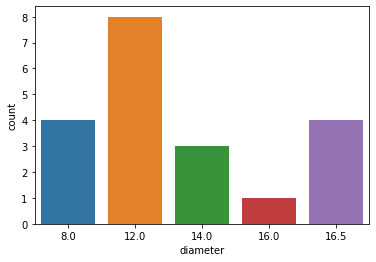

In [47]:
sns.countplot(x='diameter', data=df_regular)

Most of regular pizza have a 12 inches diameter

What about the variant?

In [48]:
df_regular.variant.value_counts()

meat_lovers          6
double_mix           6
american_favorite    3
super_supreme        3
double_signature     2
Name: variant, dtype: int64

The most popular variants are meat_lovers and double_mix.

It is still not clear what makes a regular pizza a regular pizza. The size should be related only to the diameter. For this reason, pizza with a regular size will be dropped from the dataframe.

In [49]:
df = df.loc[~(df['size'] == 'regular'),:]

In [50]:
df.head()

company  diameter       topping            variant   size  extra_sauce  \
0        A      22.0       chicken   double_signature  jumbo            1   
1        A      20.0     pepperoni   double_signature  jumbo            1   
4        A      18.0    mozzarella   double_signature  jumbo            1   
5        A      18.5  black_pepper  american_favorite  jumbo            0   
10       A      18.5    mozzarella      super_supreme  jumbo            0   

    extra_cheese  extra_mushrooms   price  
0              1                0  235000  
1              1                0  198000  
4              0                1  248000  
5              0                1  140000  
10             0                0  140000

In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105 entries, 0 to 128
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   company          105 non-null    object 
 1   diameter         105 non-null    float64
 2   topping          105 non-null    object 
 3   variant          105 non-null    object 
 4   size             105 non-null    object 
 5   extra_sauce      105 non-null    int64  
 6   extra_cheese     105 non-null    int64  
 7   extra_mushrooms  105 non-null    int64  
 8   price            105 non-null    int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 8.2+ KB


We dropped 20 regular pizzas and 4 jumbo pizzas (outliers)

# Pizza price prediction

Now it is possible to perform a regression on the price features of the pizzas.

## Encoding

In [52]:
df.head()

company  diameter       topping            variant   size  extra_sauce  \
0        A      22.0       chicken   double_signature  jumbo            1   
1        A      20.0     pepperoni   double_signature  jumbo            1   
4        A      18.0    mozzarella   double_signature  jumbo            1   
5        A      18.5  black_pepper  american_favorite  jumbo            0   
10       A      18.5    mozzarella      super_supreme  jumbo            0   

    extra_cheese  extra_mushrooms   price  
0              1                0  235000  
1              1                0  198000  
4              0                1  248000  
5              0                1  140000  
10             0                0  140000

First, we need to encode the categorical variables.<br>
Topping and variant will be encoded by One hot encoding since there is no order/hierarchy among them.<br>
Size will be encoded by label encoder since there actually exist an hierachy/order among sizes.

In [53]:
df['size'].value_counts()

medium    41
small     22
large     21
jumbo     11
XL        10
Name: size, dtype: int64

In [54]:
df['size'] = df['size'].replace('small','0')
df['size'] = df['size'].replace('medium','1')
df['size'] = df['size'].replace('large','2')
df['size'] = df['size'].replace('XL','3')
df['size'] = df['size'].replace('jumbo','4')

A new dataframe with the encoded features will be created.

In [55]:
encoded_df = df.copy()

In [56]:
categorical_cols = ['topping', 'variant','company']
encoded_df=pd.get_dummies(encoded_df , columns=categorical_cols, drop_first=True)
encoded_df.head()

diameter size  extra_sauce  extra_cheese  extra_mushrooms   price  \
0       22.0    4            1             1                0  235000   
1       20.0    4            1             1                0  198000   
4       18.0    4            1             0                1  248000   
5       18.5    4            0             0                1  140000   
10      18.5    4            0             0                0  140000   

    topping_black_pepper  topping_chicken  topping_meat  topping_mozzarella  \
0                      0                1             0                   0   
1                      0                0             0                   0   
4                      0                0             0                   1   
5                      1                0             0                   0   
10                     0                0             0                   1   

    ...  variant_neptune_tuna  variant_new_york  variant_spicy tuna  \
0   ...                     0                 0                   0   
1   ...                     0                 0                   0   
4   ...                     0                 0                   0   
5   ...                     0                 0                   0   
10  ...                     0                 0                   0   

    variant_spicy_tuna  variant_super_supreme  variant_thai_veggie  company_B  \
0                    0                      0                    0          0   
1                    0                      0                    0          0   
4                    0                      0                    0          0   
5                    0                      0                    0          0   
10                   0                      1                    0          0   

    company_C  company_D  company_E  
0           0          0          0  
1           0          0          0  
4           0          0          0  
5           0          0          0  
10          0          0          0  

[5 rows x 40 columns]

In [57]:
encoded_df.head()

diameter size  extra_sauce  extra_cheese  extra_mushrooms   price  \
0       22.0    4            1             1                0  235000   
1       20.0    4            1             1                0  198000   
4       18.0    4            1             0                1  248000   
5       18.5    4            0             0                1  140000   
10      18.5    4            0             0                0  140000   

    topping_black_pepper  topping_chicken  topping_meat  topping_mozzarella  \
0                      0                1             0                   0   
1                      0                0             0                   0   
4                      0                0             0                   1   
5                      1                0             0                   0   
10                     0                0             0                   1   

    ...  variant_neptune_tuna  variant_new_york  variant_spicy tuna  \
0   ...                     0                 0                   0   
1   ...                     0                 0                   0   
4   ...                     0                 0                   0   
5   ...                     0                 0                   0   
10  ...                     0                 0                   0   

    variant_spicy_tuna  variant_super_supreme  variant_thai_veggie  company_B  \
0                    0                      0                    0          0   
1                    0                      0                    0          0   
4                    0                      0                    0          0   
5                    0                      0                    0          0   
10                   0                      1                    0          0   

    company_C  company_D  company_E  
0           0          0          0  
1           0          0          0  
4           0          0          0  
5           0          0          0  
10          0          0          0  

[5 rows x 40 columns]

## Data preparation

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [59]:
X=encoded_df.drop('price', axis = 1).values

In [60]:
y=encoded_df['price'].values

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 69)

In [62]:
scaler = StandardScaler()

In [63]:
scaler.fit(X_train)

StandardScaler()

In [64]:
X_train = scaler.transform(X_train)          # Apply Standardization on X_train
X_test = scaler.transform(X_test)            # Apply Standardization on X_test

## Lasso model

In [65]:
from sklearn.linear_model import Ridge, Lasso

In [66]:
lm_lasso=Lasso(alpha = 10, max_iter = 1000000, tol = 1e-5)
lm_lasso.fit(X_train,y_train)
y_pred_lm_lasso = lm_lasso.predict(X_test)
mse_lm_lasso = mean_squared_error(y_test, y_pred_lm_lasso)
print("RMSE using LASSO: ", np.sqrt(mse_lm_lasso))

RMSE using LASSO:  16525.30699303791


## SVM model

In [67]:
from sklearn.svm import SVR

In [68]:
param_SVM = {'C':np.arange(1000,20000,1000),
            'gamma':[0.001,0.001,0.01,0.015,0.03,0.05,0.1,0.2,0.5]}

In [69]:
svr_model=SVR()

In [70]:
cv_SVM = GridSearchCV(estimator=svr_model, param_grid = param_SVM, cv = 5)

In [71]:
cv_SVM.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': array([ 1000,  2000,  3000,  4000,  5000,  6000,  7000,  8000,  9000,
       10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000,
       19000]),
                         'gamma': [0.001, 0.001, 0.01, 0.015, 0.03, 0.05, 0.1,
                                   0.2, 0.5]})

In [72]:
y_pred_SVM = cv_SVM.predict(X_test)

In [73]:
# Compute and print the metrics
print("Tuned SVM parameters: {}".format(cv_SVM.best_params_))

Tuned SVM parameters: {'C': 19000, 'gamma': 0.015}


In [74]:
mse_SVM = mean_squared_error(y_test, y_pred_SVM)
print("RMSE using SVM: ", np.sqrt(mse_SVM))

RMSE using SVM:  18236.846464244867


## Random Forest model

In [75]:
from sklearn.ensemble import RandomForestRegressor
param_grid = {
    'max_depth': np.arange(10,1000,10),
    'max_features': np.arange(10,1000,10),
    'n_estimators': np.arange(10,1000,10)
}

In [76]:
rf = RandomForestRegressor(n_estimators=80, max_depth=100, max_features=10)

In [77]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=100, max_features=10, n_estimators=80)

In [78]:
y_pred_rf = rf.predict(X_test)

In [79]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
print("RMSE using RF: ", np.sqrt(mse_rf))

RMSE using RF:  11577.812074043826


In [80]:
print("RF R2 score :", r2_score(y_test,y_pred_rf))

RF R2 score : 0.8504719443230266


## XGBoost

In [81]:
from xgboost import XGBRegressor

In [82]:
xgb = XGBRegressor(n_estimators=500, learning_rate=0.01) 

In [83]:
xgb.fit(X_train, y_train) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [84]:
y_pred_xgb = xgb.predict(X_test) 

In [85]:
mse_xgb = mean_squared_error(y_pred_xgb, y_test)
print("RMSE:" , np.sqrt(mse_xgb))

RMSE: 8165.875445374492


In [86]:
print("XGBoost R2 score :", r2_score(y_test,y_pred_xgb))

XGBoost R2 score : 0.9256167419685858


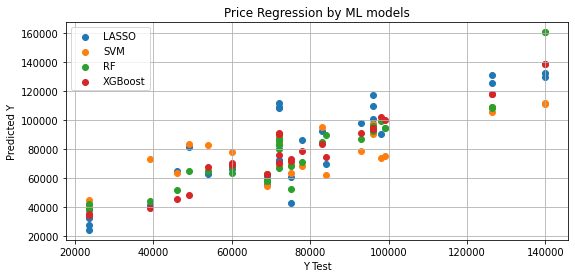

In [87]:
plt.figure(figsize = (9,4))
plt.scatter(y_test, y_pred_lm_lasso, label='LASSO')
plt.scatter(y_test, y_pred_SVM, label='SVM')
plt.scatter(y_test, y_pred_rf, label='RF')
plt.scatter(y_test, y_pred_xgb, label='XGBoost')
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.title('Price Regression by ML models')
plt.legend(loc='upper left');
plt.grid()

In [88]:
print("RMSE using LASSO: ", np.sqrt(mse_lm_lasso))
print("RMSE using SVM: ", np.sqrt(mse_SVM))
print("RMSE using RF: ", np.sqrt(mse_rf))
print("RMSE using XGBoost: ", np.sqrt(mse_xgb))

RMSE using LASSO:  16525.30699303791
RMSE using SVM:  18236.846464244867
RMSE using RF:  11577.812074043826
RMSE using XGBoost:  8165.875445374492


In [89]:
from sklearn.metrics import r2_score
print("R2 using LASSO: ", r2_score(y_test, y_pred_lm_lasso))
print("R2 using SVM: ",  r2_score(y_test, y_pred_SVM))
print("R2 using Random Forest: ",  r2_score(y_test, y_pred_rf))
print("R2 using XGBoost: ",  r2_score(y_test, y_pred_xgb))

R2 using LASSO:  0.6953727383563122
R2 using SVM:  0.6290040422011074
R2 using Random Forest:  0.8504719443230266
R2 using XGBoost:  0.9256167419685858


We get the best result in terms of RMSE and R2 by using XGBoost regressor.